# 1. Set up the notebook

Do imports.

In [1]:
import numpy as np
import sympy as sym
from scipy import linalg
import json
import matplotlib.pyplot as plt
from ae483tools import *

Define a function to solve the linear quadratic regulator (LQR) problem - i.e., that finds the matrix $K$ for which

$$u(t) = - K x(t)$$

is the optimal solution to

$$
\begin{align*}
\underset{u_{[t_{0}, \infty)}}{\text{minimize}} &\qquad \int_{t_{0}}^{\infty}\left( x(t)^{T}Qx(t)+u(t)^{T}Ru(t)\right)dt \\
\text{subject to} &\qquad \dot{x}(t) = Ax(t)+Bu(t), \quad x(t_{0})=x_{0}.
\end{align*}
$$

In [2]:
def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @  B.T @ P
    return K

Define a function to create the observability matrix

$$ W_o = \begin{bmatrix} C \\ CA \\ CA^2 \\ \vdots \\ CA^{n-1} \end{bmatrix} $$

where $A$ has size $n \times n$.

In [3]:
def obsv(A, C):
    W = C
    for i in range(1, A.shape[0]):
        W = np.vstack([W, C @ np.linalg.matrix_power(A, i)])
    return W

Check mocap coverage from `lab07_square02.json`.

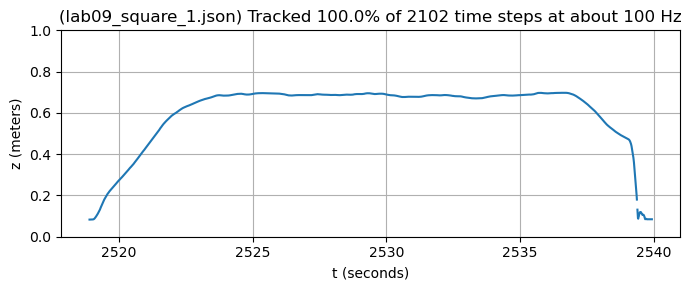

In [5]:
check_mocap_coverage('lab09_square_1.json')

# 2. Design observer

## 2.1 Define state-space model and load parameter values

Load the matrices that describe the state-space model

$$\begin{align*} \dot{x} &= Ax + Bu \\ y &= Cx + Bu \end{align*}$$

that was derived previously. Also load the parameter values $g$, $k_\text{flow}$, and $p_{z,\text{eq}}$.

In [6]:
# Load model
with open('model.json', 'r') as f:
    model = json.load(f)

# Parse model
A = np.array(model['A'])
B = np.array(model['B'])
C = np.array(model['C'])
D = np.array(model['D'])
g = model['g']
k_flow = model['k_flow']
p_z_eq = model['p_z_eq']
d_carpet = model['d_carpet']

# Show model
A_str = np.array2string(A,
                formatter={'float_kind': lambda x: f'{x:7.4f}'},
                separator=', ',
                prefix=' '*len('A = '),
                max_line_width=np.inf)
B_str = np.array2string(B,
                formatter={'float_kind': lambda x: f'{x:7.4f}'},
                separator=', ',
                prefix=' '*len('B = '),
                max_line_width=np.inf)
C_str = np.array2string(C,
                formatter={'float_kind': lambda x: f'{x:7.4f}'},
                separator=', ',
                prefix=' '*len('C = '),
                max_line_width=np.inf)
D_str = np.array2string(D,
                formatter={'float_kind': lambda x: f'{x:7.4f}'},
                separator=', ',
                prefix=' '*len('D = '),
                max_line_width=np.inf)
print('STATE-SPACE MODEL')
print(f'A = {A_str}')
print(f'B = {B_str}')
print(f'C = {C_str}')
print(f'D = {D_str}')
print('PARAMETER VALUES')
print(f'g      = {g:7.4f}')
print(f'k_flow = {k_flow:7.4f}')
print(f'p_z_eq = {p_z_eq:7.4f}')
print(f'd_carpet = {d_carpet:7.4f}')

# Check that all numbers in model are finite (i.e., not Inf, not NaN)
assert(np.all(np.isfinite(A)))
assert(np.all(np.isfinite(B)))
assert(np.all(np.isfinite(C)))
assert(np.all(np.isfinite(D)))

STATE-SPACE MODEL
A = [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  9.8100,  0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -9.8100,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]
B = [[ 0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000],
     [ 0.0000,  0.0000,  1.0000,  0.0000],
     [ 0.0000,  1.

## 2.2 Show that not all states are observable

Find the observability matrix

$$ W_o = \begin{bmatrix} C \\ CA \\ CA^2 \\ \vdots \\ CA^{n-1} \end{bmatrix} $$

where $A$ is $n \times n$.

In [7]:
W_o = obsv(A, C)

Find the rank of the observability matrix using [numpy.linalg.matrix_rank](https://numpy.org/doc/stable/reference/generated/numpy.linalg.matrix_rank.html). The system is **observable** if and only if $W_o$ is **full rank**, that is, if its rank is equal to the number of states $n$.

In [8]:
print(f'      rank of W_o is: {np.linalg.matrix_rank(W_o)}')
print(f'"full rank" would be: {A.shape[0]}')

      rank of W_o is: 9
"full rank" would be: 9


If the system is *not* observable, then it is impossible to design a stable observer - that is, an observer that makes the error in your estimate of each state converge to zero over time.

In particular, the following code would produce an error if you tried to use it:
```python
# Choose weights
Q = np.eye(3) # <-- one diagonal entry for each output
R = np.eye(9) # <-- one diagonal entry for each state

# Find gain matrix
L = lqr(A.T, C.T, linalg.inv(R), linalg.inv(Q)).T
```
It does not matter what method you use - if it is impossible to design a stable observer, that's it, you're out of luck!

## 2.3 Choose a subset of states that are observable

List the index of each state to include.

In [9]:
# FIXME: delete the index of each state that is not observable!

s_obs_index = [
    0, # p_x
    1, # p_y
    2, # p_z
    3, # psi
    4, # theta
    5, # phi
    6, # v_x
    7, # v_y
    8, # v_z
]

Define a state-space model

$$
\begin{align*}
\dot{x}_\text{obs} = A_\text{obs} x_\text{obs} + B_\text{obs} u \\
y = C_\text{obs} x_\text{obs} + D_\text{obs} u
\end{align*}
$$

with only these states.

In [10]:
A_obs = A[s_obs_index, :][:, s_obs_index]
B_obs = B[s_obs_index, :]
C_obs = C[:, s_obs_index]
D_obs = D

Show the matrices that describe this state-space model.

In [11]:
print(f'A_obs:\n{A_obs}\n')
print(f'B_obs:\n{B_obs}\n')
print(f'C_obs:\n{C_obs}\n')
print(f'D_obs:\n{D_obs}\n')

A_obs:
[[ 0.    0.    0.    0.    0.    0.    1.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    1.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    1.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    9.81  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.   -9.81  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]

B_obs:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]]

C_obs:
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]]

D_obs:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]



Check that this subsystem is observable:

In [12]:
print(f'      rank of W_o is: {np.linalg.matrix_rank(obsv(A_obs, C_obs))}')
print(f'"full rank" would be: {A_obs.shape[0]}')

      rank of W_o is: 9
"full rank" would be: 9


## 2.4 Choose gain matrix for the observable subsystem

### 2.4.1 With equal weights

Choose weights $Q$ and $R$ as identity matrices.

In [13]:
# FIXME: change the size of each identity matrix to match the
# number of states and outputs for your observable subsystem

Q = np.eye(6) # <-- one diagonal entry for each output
R = np.eye(9) # <-- one diagonal entry for each state

Find gain matrix $L$ for the chosen $Q$ and $R$ by solving an LQR problem.

In [14]:
L = lqr(A_obs.T, C_obs.T, linalg.inv(R), linalg.inv(Q)).T

Show $L$ (formatted nicely).

In [15]:
L_str = np.array2string(L,
                        formatter={'float_kind': lambda x: f'{x:12.6f}'},
                        prefix='    ',
                        max_line_width=np.inf)

print(f'L = {L_str}')

L = [[    3.878403     0.000000     0.000000     0.000000     0.677742     0.000000]
     [    0.000000     3.878403     0.000000     0.000000     0.000000    -0.677742]
     [    0.000000     0.000000     1.732051     0.000000     0.000000     0.000000]
     [    0.000000     0.000000     0.000000     1.000000     0.000000     0.000000]
     [    0.677742     0.000000     0.000000     0.000000     0.735300     0.000000]
     [    0.000000    -0.677742     0.000000     0.000000     0.000000     0.735300]
     [    7.250674     0.000000     0.000000     0.000000     3.126899     0.000000]
     [    0.000000     7.250674     0.000000     0.000000     0.000000    -3.126899]
     [    0.000000     0.000000     1.000000     0.000000     0.000000     0.000000]]


### 2.4.2 With weights chosen by model error variance

Choose weights $Q$ and $R$ based on variance of model error.

In [16]:
Q = np.diag([
    # (1/1.723)**2,             # n_x
    # # 0.0005,
    # (1/1.564)**2,             # n_y
    # # 0.001,
    # (1/0.003)**2,             # r
    (1/0.002)**2,             # p_x_mocap 
    (1/0.003)**2,             # p_y_mocap
    (1/0.007)**2,             # p_z_mocap
    (1/0.003)**2,             # psi_mocap
    (1/0.005)**2,             # theta_mocap
    (1/0.004)**2              # phi_mocap
    
])

R = np.diag([
    (1/0.039)**2,          # p_x
    (1/0.032)**2,          # p_y
    (1/0.042)**2,          # p_z
    (1/0.020)**2,          # psi
    (1/0.046)**2,          # theta
    (1/0.042)**2,          # phi
    # (1/0.232)**2, # v_x
    (1/0.059)**2,          # v_x
    # 4000,
    (1/0.090)**2,          # v_y
    # 4000,
    (1/0.193)**2,          # v_z
])

In [17]:
Q_terms = ['p_x_mocap', 'p_y_mocap', 'p_z_mocap', 'psi_mocap', 'theta_mocap', 'phi_mocap']
R_terms = ['p_x', 'p_y', 'p_z', 'psi', 'theta', 'phi', 'v_x', 'v_y', 'v_z']

for i in range(len(Q)):
    print(f'The value of {Q_terms[i]} is {Q[i, i]}')

print('\n')

for i in range(len(R)):
    print(f'The value of {R_terms[i]} is {R[i, i]}')

The value of p_x_mocap is 250000.0
The value of p_y_mocap is 111111.1111111111
The value of p_z_mocap is 20408.163265306124
The value of psi_mocap is 111111.1111111111
The value of theta_mocap is 40000.0
The value of phi_mocap is 62500.0


The value of p_x is 657.4621959237345
The value of p_y is 976.5625
The value of p_z is 566.8934240362811
The value of psi is 2500.0
The value of theta is 472.5897920604915
The value of phi is 566.8934240362811
The value of v_x is 287.27377190462516
The value of v_y is 123.45679012345678
The value of v_z is 26.846358291497754


Find gain matrix $L$ for the chosen $Q$ and $R$ by solving an LQR problem.

In [18]:
L = lqr(A_obs.T, C_obs.T, linalg.inv(R), linalg.inv(Q)).T

Show $L$ (formatted nicely).

In [19]:
L_str = np.array2string(L,
                        formatter={'float_kind': lambda x: f'{x:12.6f}'},
                        prefix='    ',
                        max_line_width=np.inf)

print(f'L = {L_str}')
print('L = np.array([', end='')
for i in range(0, len(L)):
    for j in range(0, len(L[0])):
        if j == 0:
            print('[', end='')
        print(f'{L[i, j]:.3g}, ', end='')
        if j == len(L[0])-1:
            if i < len(L)-1:
                print('],')
            else:
                print(']])')

L = [[   21.360009     0.000000     0.000000     0.000000     0.282687     0.000000]
     [    0.000000    13.376393     0.000000     0.000000     0.000000    -0.363574]
     [    0.000000     0.000000     9.546877     0.000000     0.000000     0.000000]
     [    0.000000     0.000000     0.000000     6.666667     0.000000     0.000000]
     [    1.766792     0.000000     0.000000     0.000000     9.172816     0.000000]
     [    0.000000    -0.646354     0.000000     0.000000     0.000000    10.488804]
     [   38.249721     0.000000     0.000000     0.000000     8.631225     0.000000]
     [    0.000000    32.692558     0.000000     0.000000     0.000000    -8.676775]
     [    0.000000     0.000000    27.571429     0.000000     0.000000     0.000000]]
L = np.array([[21.4, 0, 0, 0, 0.283, 0, ],
[0, 13.4, 0, 0, 0, -0.364, ],
[0, 0, 9.55, 0, 0, 0, ],
[0, 0, 0, 6.67, 0, 0, ],
[1.77, 0, 0, 0, 9.17, 0, ],
[0, -0.646, 0, 0, 0, 10.5, ],
[38.2, 0, 0, 0, 8.63, 0, ],
[0, 32.7, 0, 0, 0, -8.68,

In [20]:
err = ['p_x - p_x_mocap',
       'p_y - p_y_mocap',
       'p_z - p_z_mocap',
       'psi - psi_mocap',
       'theta - theta_mocap',
       'phi - phi_mocap']

AxBu = ['v_x',
        'v_y',
        'v_z',
        'w_z',
        'w_y',
        'w_x',
        'a_z_0*theta',
        '-a_z_0*phi',
        'a_z-a_z_0']

x_list = ['p_x',
          'p_y',
          'p_z',
          'psi',
          'theta',
          'phi',
          'v_x',
          'v_y',
          'v_z']

for i in range(len(err)):
    print('err_'+str(i)+' = '+err[i]+';')
for i in range(len(x_list)):
    RHS = []
    for j in range(len(L[0])):
        RHS.append(str(L[i, j])+'f*err_'+str(j))
    full_RHS = ''
    for j in range(len(RHS)):
        if np.abs(L[i, j]) > 1e-10:
            full_RHS += RHS[j] + ' + '
    full_RHS = full_RHS.rstrip(' + ')
    print(x_list[i] + ' += dt*(' + AxBu[i] + ' - (' + full_RHS + '));')

err_0 = p_x - p_x_mocap;
err_1 = p_y - p_y_mocap;
err_2 = p_z - p_z_mocap;
err_3 = psi - psi_mocap;
err_4 = theta - theta_mocap;
err_5 = phi - phi_mocap;
p_x += dt*(v_x - (21.360009220808184f*err_0 + 0.2826867366281751f*err_4));
p_y += dt*(v_y - (13.376393263769792f*err_1 + -0.36357440306896455f*err_5));
p_z += dt*(v_z - (9.546876826630623f*err_2));
psi += dt*(w_z - (6.666666666666666f*err_3));
theta += dt*(w_y - (1.7667921039260945f*err_0 + 9.172815887492872f*err_4));
phi += dt*(w_x - (-0.6463544943448256f*err_1 + 10.488803652016216f*err_5));
v_x += dt*(a_z_0*theta - (38.24972130358482f*err_0 + 8.631224689902758f*err_4));
v_y += dt*(-a_z_0*phi - (32.69255845930459f*err_1 + -8.676774722744474f*err_5));
v_z += dt*(a_z-a_z_0 - (27.571428571428402f*err_2));


In [21]:
for i in range(len(err)):
    print('err_'+str(i)+' = '+err[i])
for i in range(len(x_list)):
    RHS = []
    for j in range(len(L[0])):
        RHS.append(str(L[i, j])+'*err_'+str(j))
    full_RHS = ''
    for j in range(len(RHS)):
        if np.abs(L[i, j]) > 1e-10:
            full_RHS += RHS[j] + ' + '
    full_RHS = full_RHS.rstrip(' + ')
    print(x_list[i] + ' += dt*(' + AxBu[i] + ' - (' + full_RHS + '))')

err_0 = p_x - p_x_mocap
err_1 = p_y - p_y_mocap
err_2 = p_z - p_z_mocap
err_3 = psi - psi_mocap
err_4 = theta - theta_mocap
err_5 = phi - phi_mocap
p_x += dt*(v_x - (21.360009220808184*err_0 + 0.2826867366281751*err_4))
p_y += dt*(v_y - (13.376393263769792*err_1 + -0.36357440306896455*err_5))
p_z += dt*(v_z - (9.546876826630623*err_2))
psi += dt*(w_z - (6.666666666666666*err_3))
theta += dt*(w_y - (1.7667921039260945*err_0 + 9.172815887492872*err_4))
phi += dt*(w_x - (-0.6463544943448256*err_1 + 10.488803652016216*err_5))
v_x += dt*(a_z_0*theta - (38.24972130358482*err_0 + 8.631224689902758*err_4))
v_y += dt*(-a_z_0*phi - (32.69255845930459*err_1 + -8.676774722744474*err_5))
v_z += dt*(a_z-a_z_0 - (27.571428571428402*err_2))


# 3. Implement and test observer (offline)

## 3.1 Load and parse flight data

**Replace this cell** with a description of the flight trajectory, flight conditions, flight settings (e.g., what was the value of `use_controller`), etc., that produced the data `lab07_square02.json` you are using in this section.

Load flight data.

In [23]:
# Load flight data
raw_data_drone, raw_data_mocap = load_hardware_data('lab09_square_1.json')

# Resample drone data
data_drone = resample_data_drone(
    raw_data_drone,
    t_min_offset=0., # <-- FIXME
    t_max_offset=0., # <-- FIXME
)

# Sync and resample mocap data
data_mocap = sync_data_mocap(raw_data_mocap, data_drone['time'], data_drone['ae483log.p_z'])

# Only look at data from when the drone was actually flying
only_in_flight(data_drone, data_mocap=data_mocap)

Shifting data by -0.02 seconds
Increment for shifting: -0.01
0.018805787209552973 0.018873593762843335 0.018767049094522936


Parse flight data. We label state estimates from the drone as `_default` to indicate that they come from the default observer.

In [24]:
# time
t = data_drone['time']

# state estimates from default observer
p_x_default = data_drone['ae483log.p_x']
p_y_default = data_drone['ae483log.p_y']
p_z_default = data_drone['ae483log.p_z']
psi_default = data_drone['ae483log.psi']
theta_default = data_drone['ae483log.theta']
phi_default = data_drone['ae483log.phi']
v_x_default = data_drone['ae483log.v_x']
v_y_default = data_drone['ae483log.v_y']
v_z_default = data_drone['ae483log.v_z']

# state estimates from the motion capture system
p_x_mocap = data_drone['ae483log.p_x_mocap']
p_y_mocap = data_drone['ae483log.p_y_mocap']
p_z_mocap = data_drone['ae483log.p_z_mocap']
psi_mocap = data_drone['ae483log.psi_mocap']
theta_mocap = data_drone['ae483log.theta_mocap']
phi_mocap = data_drone['ae483log.phi_mocap']

Define parameter values.

In [25]:
dt = t[1] - t[0]
print(f'dt = {dt:.4f}')
assert(np.isclose(dt, 0.01))

dt = 0.0100


## 3.2 Apply observer for gain matrix chosen by model variance

Implement and run your observer in the following code cell.

For each state, the result will be a numpy array (e.g., `p_x_offline`) that contains a state estimate at every time step. We label state estimates as `_offline` to indicate that they come from a custom observer that has been implemented offline. We also label the arrays of inputs (e.g., `w_x_offline`) and outputs (e.g., `n_x_offline`) as `_offline` to indicate that they are being used by a custom observer that has been implemented offline.

In [26]:
# Get inputs
w_x_offline = data_drone['ae483log.w_x']
w_y_offline = data_drone['ae483log.w_y']
w_z_offline = data_drone['ae483log.w_z']
a_z_offline = data_drone['ae483log.a_z']

# Get outputs
# n_x_offline = data_drone['ae483log.n_x']
# n_y_offline = data_drone['ae483log.n_y']
# r_offline = data_drone['ae483log.r']
p_x_mocap_offline   = data_drone['ae483log.p_x_mocap']
p_y_mocap_offline   = data_drone['ae483log.p_y_mocap']
p_z_mocap_offline   = data_drone['ae483log.p_z_mocap']
psi_mocap_offline   = data_drone['ae483log.psi_mocap']
theta_mocap_offline = data_drone['ae483log.theta_mocap']
phi_mocap_offline   = data_drone['ae483log.phi_mocap']


# Initialize estimates
p_x = 0.
p_y = 0.
p_z = 0.
psi = 0.
theta = 0.
phi = 0.
v_x = 0.
v_y = 0.
v_z = 0.
a_z_0 = a_z_offline[0]

# Initialize storage (do not change)
p_x_offline = np.zeros(len(t))
p_y_offline = np.zeros(len(t))
p_z_offline = np.zeros(len(t))
psi_offline = np.zeros(len(t))
theta_offline = np.zeros(len(t))
phi_offline = np.zeros(len(t))
v_x_offline = np.zeros(len(t))
v_y_offline = np.zeros(len(t))
v_z_offline = np.zeros(len(t))

# Iterate over all time steps
for i in range(len(t)):
    # Get measurements (do not change)
    w_x = w_x_offline[i]
    w_y = w_y_offline[i]
    w_z = w_z_offline[i]
    a_z = a_z_offline[i]
    # n_x = n_x_offline[i]
    # n_y = n_y_offline[i]
    # r = r_offline[i]
    p_x_mocap = p_x_mocap_offline[i]
    p_y_mocap = p_y_mocap_offline[i]
    p_z_mocap = p_z_mocap_offline[i]
    psi_mocap = psi_mocap_offline[i]
    theta_mocap  = theta_mocap_offline[i]
    phi_mocap = phi_mocap_offline[i]


    
    # Compute each element of:
    #
# Get inputs
w_x_offline = data_drone['ae483log.w_x']
w_y_offline = data_drone['ae483log.w_y']
w_z_offline = data_drone['ae483log.w_z']
a_z_offline = data_drone['ae483log.a_z']

# Get outputs
# n_x_offline = data_drone['ae483log.n_x']
# n_y_offline = data_drone['ae483log.n_y']
# r_offline = data_drone['ae483log.r']
p_x_mocap_offline   = data_drone['ae483log.p_x_mocap']
p_y_mocap_offline   = data_drone['ae483log.p_y_mocap']
p_z_mocap_offline   = data_drone['ae483log.p_z_mocap']
psi_mocap_offline   = data_drone['ae483log.psi_mocap']
theta_mocap_offline = data_drone['ae483log.theta_mocap']
phi_mocap_offline   = data_drone['ae483log.phi_mocap']


# Initialize estimates
p_x = 0.
p_y = 0.
p_z = 0.
psi = 0.
theta = 0.
phi = 0.
v_x = 0.
v_y = 0.
v_z = 0.
a_z_0 = a_z_offline[0]

# Initialize storage (do not change)
p_x_offline = np.zeros(len(t))
p_y_offline = np.zeros(len(t))
p_z_offline = np.zeros(len(t))
psi_offline = np.zeros(len(t))
theta_offline = np.zeros(len(t))
phi_offline = np.zeros(len(t))
v_x_offline = np.zeros(len(t))
v_y_offline = np.zeros(len(t))
v_z_offline = np.zeros(len(t))

# Iterate over all time steps
for i in range(len(t)):
    # Get measurements (do not change)
    w_x = w_x_offline[i]
    w_y = w_y_offline[i]
    w_z = w_z_offline[i]
    a_z = a_z_offline[i]
    # n_x = n_x_offline[i]
    # n_y = n_y_offline[i]
    # r = r_offline[i]
    p_x_mocap = p_x_mocap_offline[i]
    p_y_mocap = p_y_mocap_offline[i]
    p_z_mocap = p_z_mocap_offline[i]
    psi_mocap = psi_mocap_offline[i]
    theta_mocap  = theta_mocap_offline[i]
    phi_mocap = phi_mocap_offline[i]


    
    # Compute each element of:
    #
    err_0 = p_x - p_x_mocap
    err_1 = p_y - p_y_mocap
    err_2 = p_z - p_z_mocap
    err_3 = psi - psi_mocap
    err_4 = theta - theta_mocap
    err_5 = phi - phi_mocap
    p_x += dt*(v_x - (19.88640059336123*err_0 + 0.26920920812040056*err_4))
    p_y += dt*(v_y - (11.235803213396196*err_1 + -0.49010250299907365*err_5))
    p_z += dt*(v_z - (6.08230711439294*err_2))
    psi += dt*(w_z - (1.5*err_3))
    theta += dt*(w_y - (0.7478033558900014*err_0 + 2.560992864248374*err_4))
    phi += dt*(w_x - (-0.1458156207269972*err_1 + 3.48977583797374*err_5))
    v_x += dt*(a_z_0*theta - (35.8351220544533*err_0 + 6.043045017090066*err_4))
    v_y += dt*(-a_z_0*phi - (18.46315434939661*err_1 + -7.217043151186782*err_5))
    v_z += dt*(a_z-a_z_0 - (14.894736842105242*err_2))

    # Store estimates (do not change)
    p_x_offline[i] = p_x
    p_y_offline[i] = p_y
    p_z_offline[i] = p_z
    psi_offline[i] = psi
    theta_offline[i] = theta
    phi_offline[i] = phi
    v_x_offline[i] = v_x
    v_y_offline[i] = v_y
    v_z_offline[i] = v_z


    # Store estimates (do not change)
    p_x_offline[i] = p_x
    p_y_offline[i] = p_y
    p_z_offline[i] = p_z
    psi_offline[i] = psi
    theta_offline[i] = theta
    phi_offline[i] = phi
    v_x_offline[i] = v_x
    v_y_offline[i] = v_y
    v_z_offline[i] = v_z


Compute error in each state estimate (relative to state estimates produced by the default observer and logged during the flight test).

In [27]:
p_x_err = p_x_offline - p_x_default
p_y_err = p_y_offline - p_y_default
p_z_err = p_z_offline - p_z_default
psi_err = psi_offline - psi_default
theta_err = theta_offline - theta_default
phi_err = phi_offline - phi_default
v_x_err = v_x_offline - v_x_default
v_y_err = v_y_offline - v_y_default
v_z_err = v_z_offline - v_z_default

Compare estimates with those produced by (1) the default observer and (2) the motion capture system.

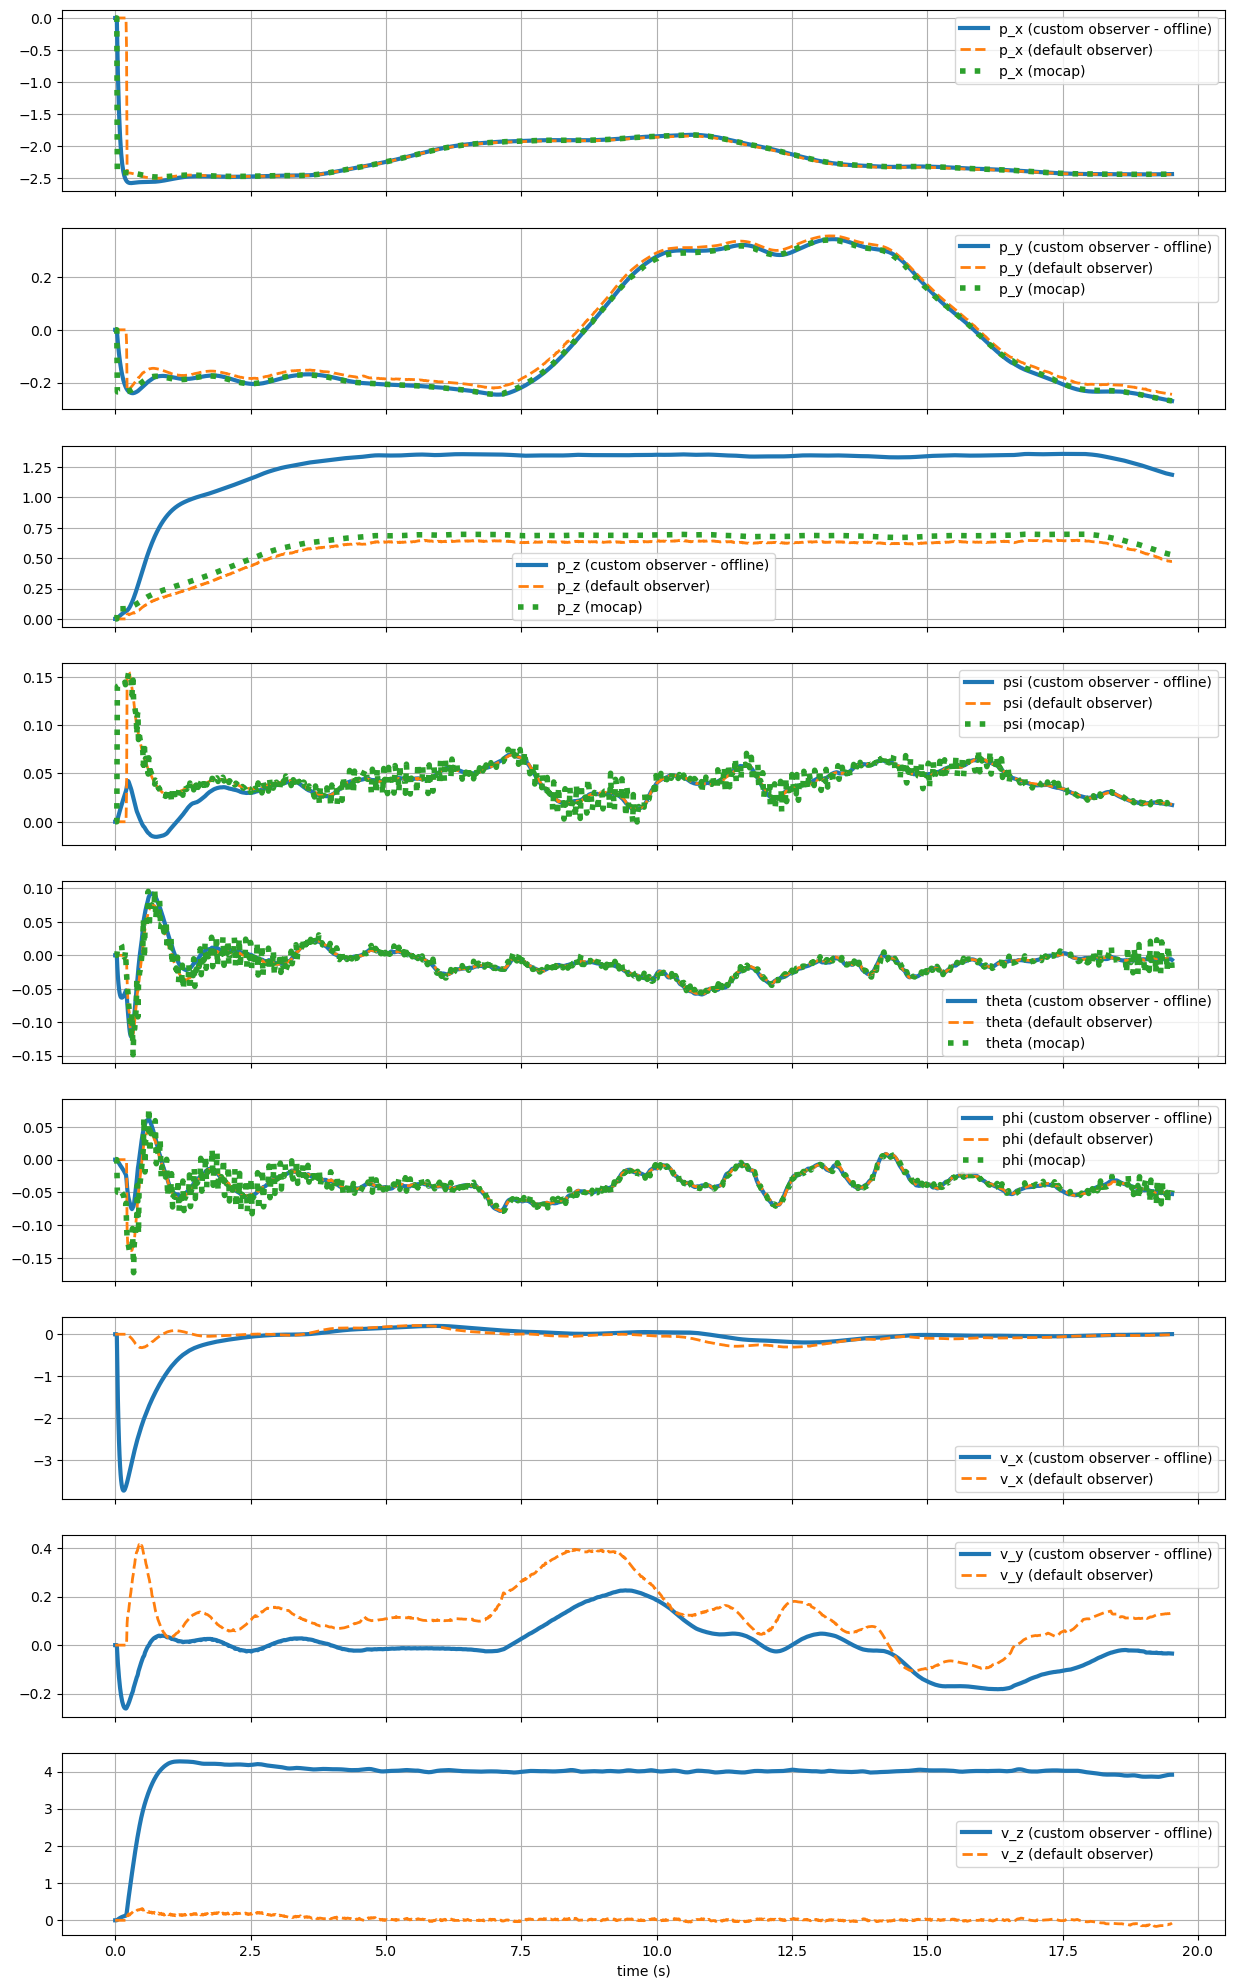

In [28]:
def comparison_plot(t, s_offline, s_default, name, ax, s_mocap=None):
    ax.plot(t, s_offline, label=f'{name} (custom observer - offline)', linewidth=3)
    ax.plot(t, s_default, '--', label=f'{name} (default observer)', linewidth=2)
    if s_mocap is not None:
        ax.plot(t, s_mocap, ':', label=f'{name} (mocap)', linewidth=4)
    ax.legend()
    ax.grid()

fig, (ax_p_x,
      ax_p_y,
      ax_p_z,
      ax_psi,
      ax_theta,
      ax_phi,
      ax_v_x,
      ax_v_y,
      ax_v_z) = plt.subplots(9, 1, figsize=(15, 25), sharex=True)
comparison_plot(t, p_x_offline, p_x_default, 'p_x', ax_p_x, s_mocap=p_x_mocap_offline)
comparison_plot(t, p_y_offline, p_y_default, 'p_y', ax_p_y, s_mocap=p_y_mocap_offline)
comparison_plot(t, p_z_offline, p_z_default, 'p_z', ax_p_z, s_mocap=p_z_mocap_offline)
comparison_plot(t, psi_offline, psi_default, 'psi', ax_psi, s_mocap=psi_mocap_offline)
comparison_plot(t, theta_offline, theta_default, 'theta', ax_theta, s_mocap=theta_mocap_offline)
comparison_plot(t, phi_offline, phi_default, 'phi', ax_phi, s_mocap=phi_mocap_offline)
comparison_plot(t, v_x_offline, v_x_default, 'v_x', ax_v_x)
comparison_plot(t, v_y_offline, v_y_default, 'v_y', ax_v_y)
comparison_plot(t, v_z_offline, v_z_default, 'v_z', ax_v_z)
ax_v_z.set_xlabel('time (s)')
plt.show()

Plot error in each state estimate with respect to ground truth.

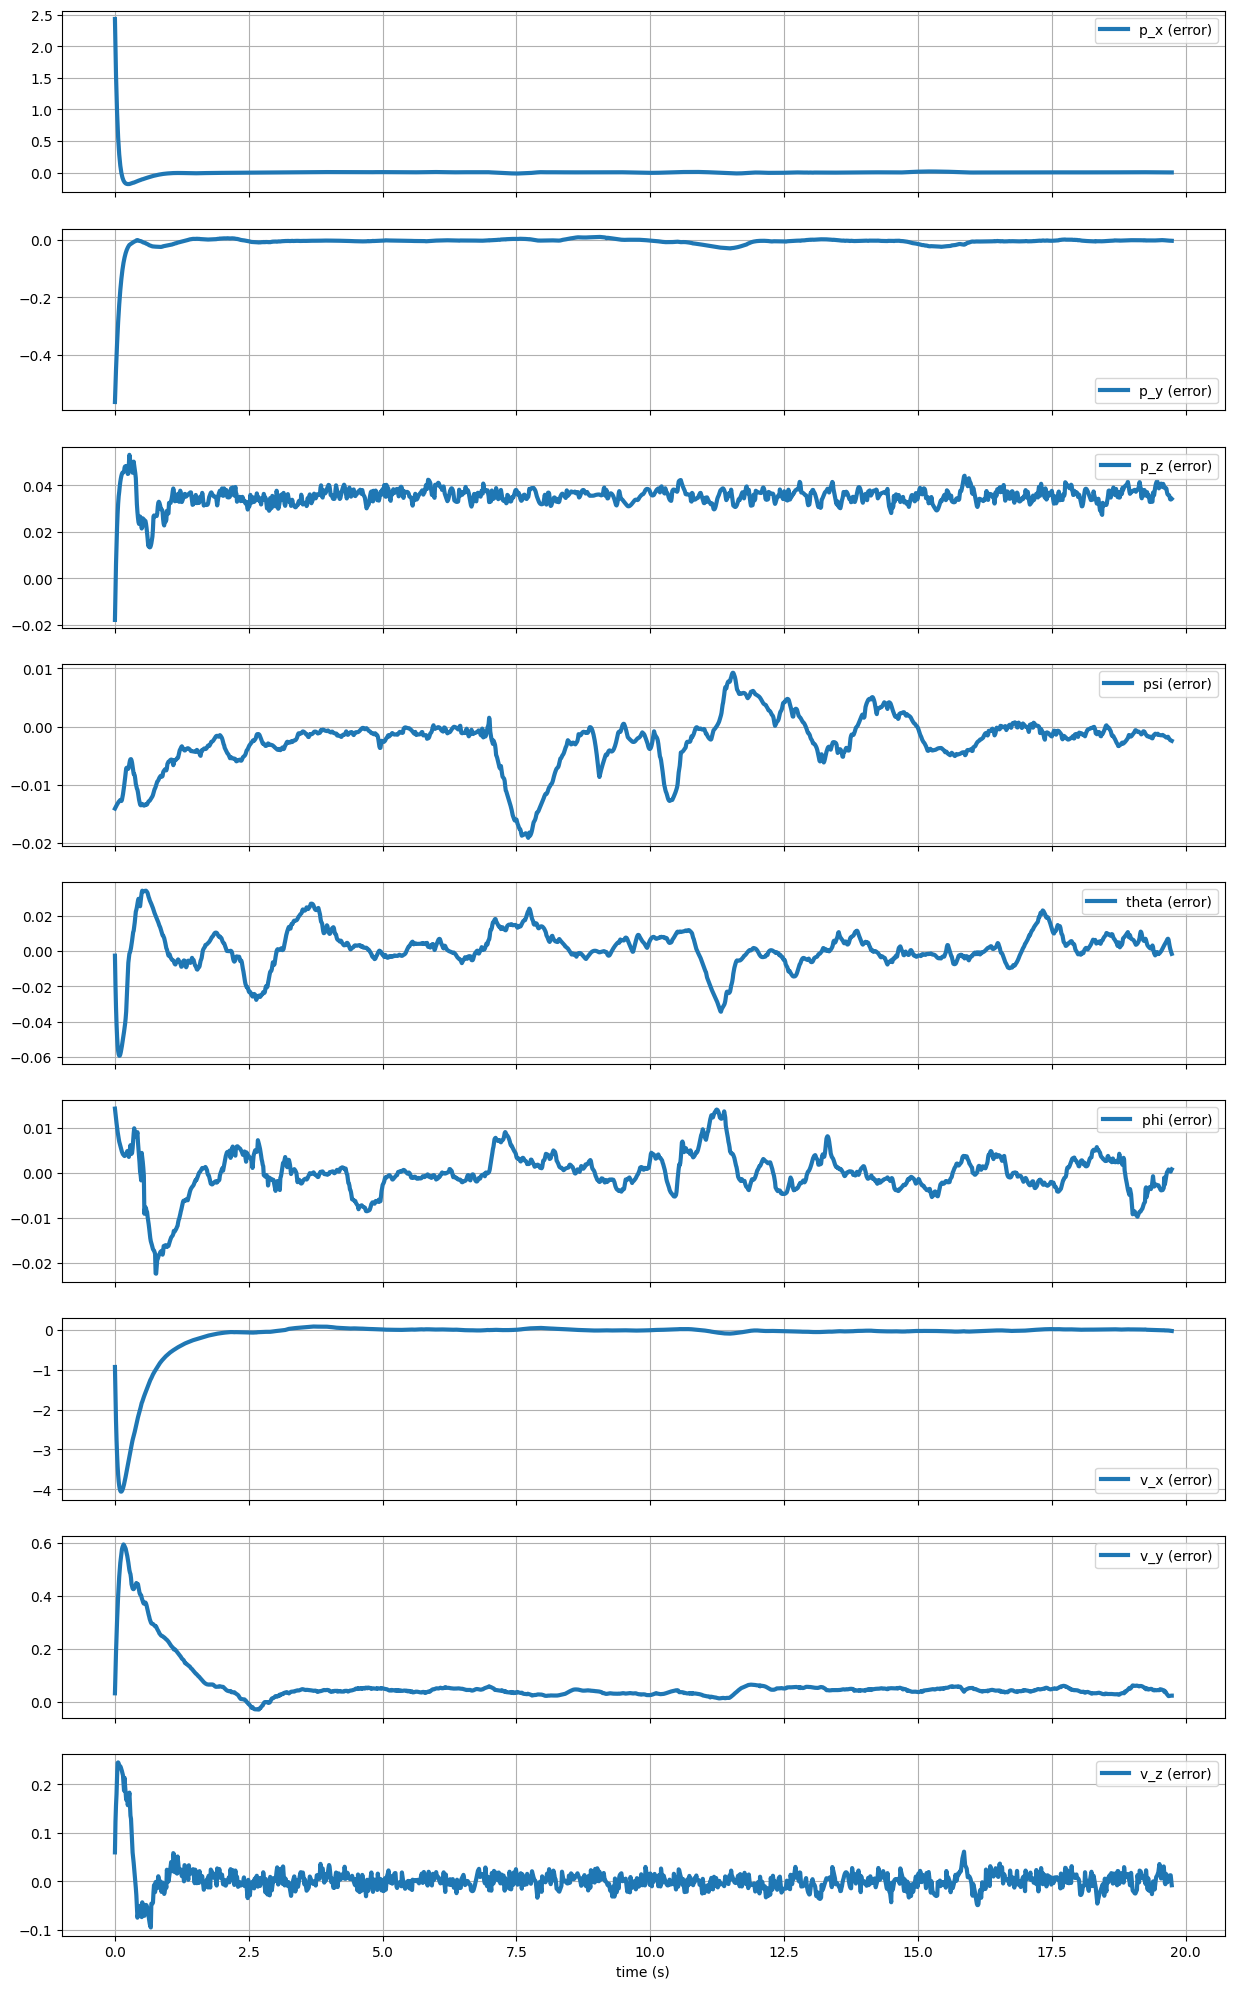

In [85]:
def error_plot(t, s_err, name, ax):
    ax.plot(t, s_err, label=f'{name} (error)', linewidth=3)
    ax.legend()
    ax.grid()

fig, (ax_p_x,
      ax_p_y,
      ax_p_z,
      ax_psi,
      ax_theta,
      ax_phi,
      ax_v_x,
      ax_v_y,
      ax_v_z) = plt.subplots(9, 1, figsize=(15, 25), sharex=True)
error_plot(t, p_x_err, 'p_x', ax_p_x)
error_plot(t, p_y_err, 'p_y', ax_p_y)
error_plot(t, p_z_err, 'p_z', ax_p_z)
error_plot(t, psi_err, 'psi', ax_psi)
error_plot(t, theta_err, 'theta', ax_theta)
error_plot(t, phi_err, 'phi', ax_phi)
error_plot(t, v_x_err, 'v_x', ax_v_x)
error_plot(t, v_y_err, 'v_y', ax_v_y)
error_plot(t, v_z_err, 'v_z', ax_v_z)
ax_v_z.set_xlabel('time (s)')
plt.show()

Plot histogram of errors in each state estimate.

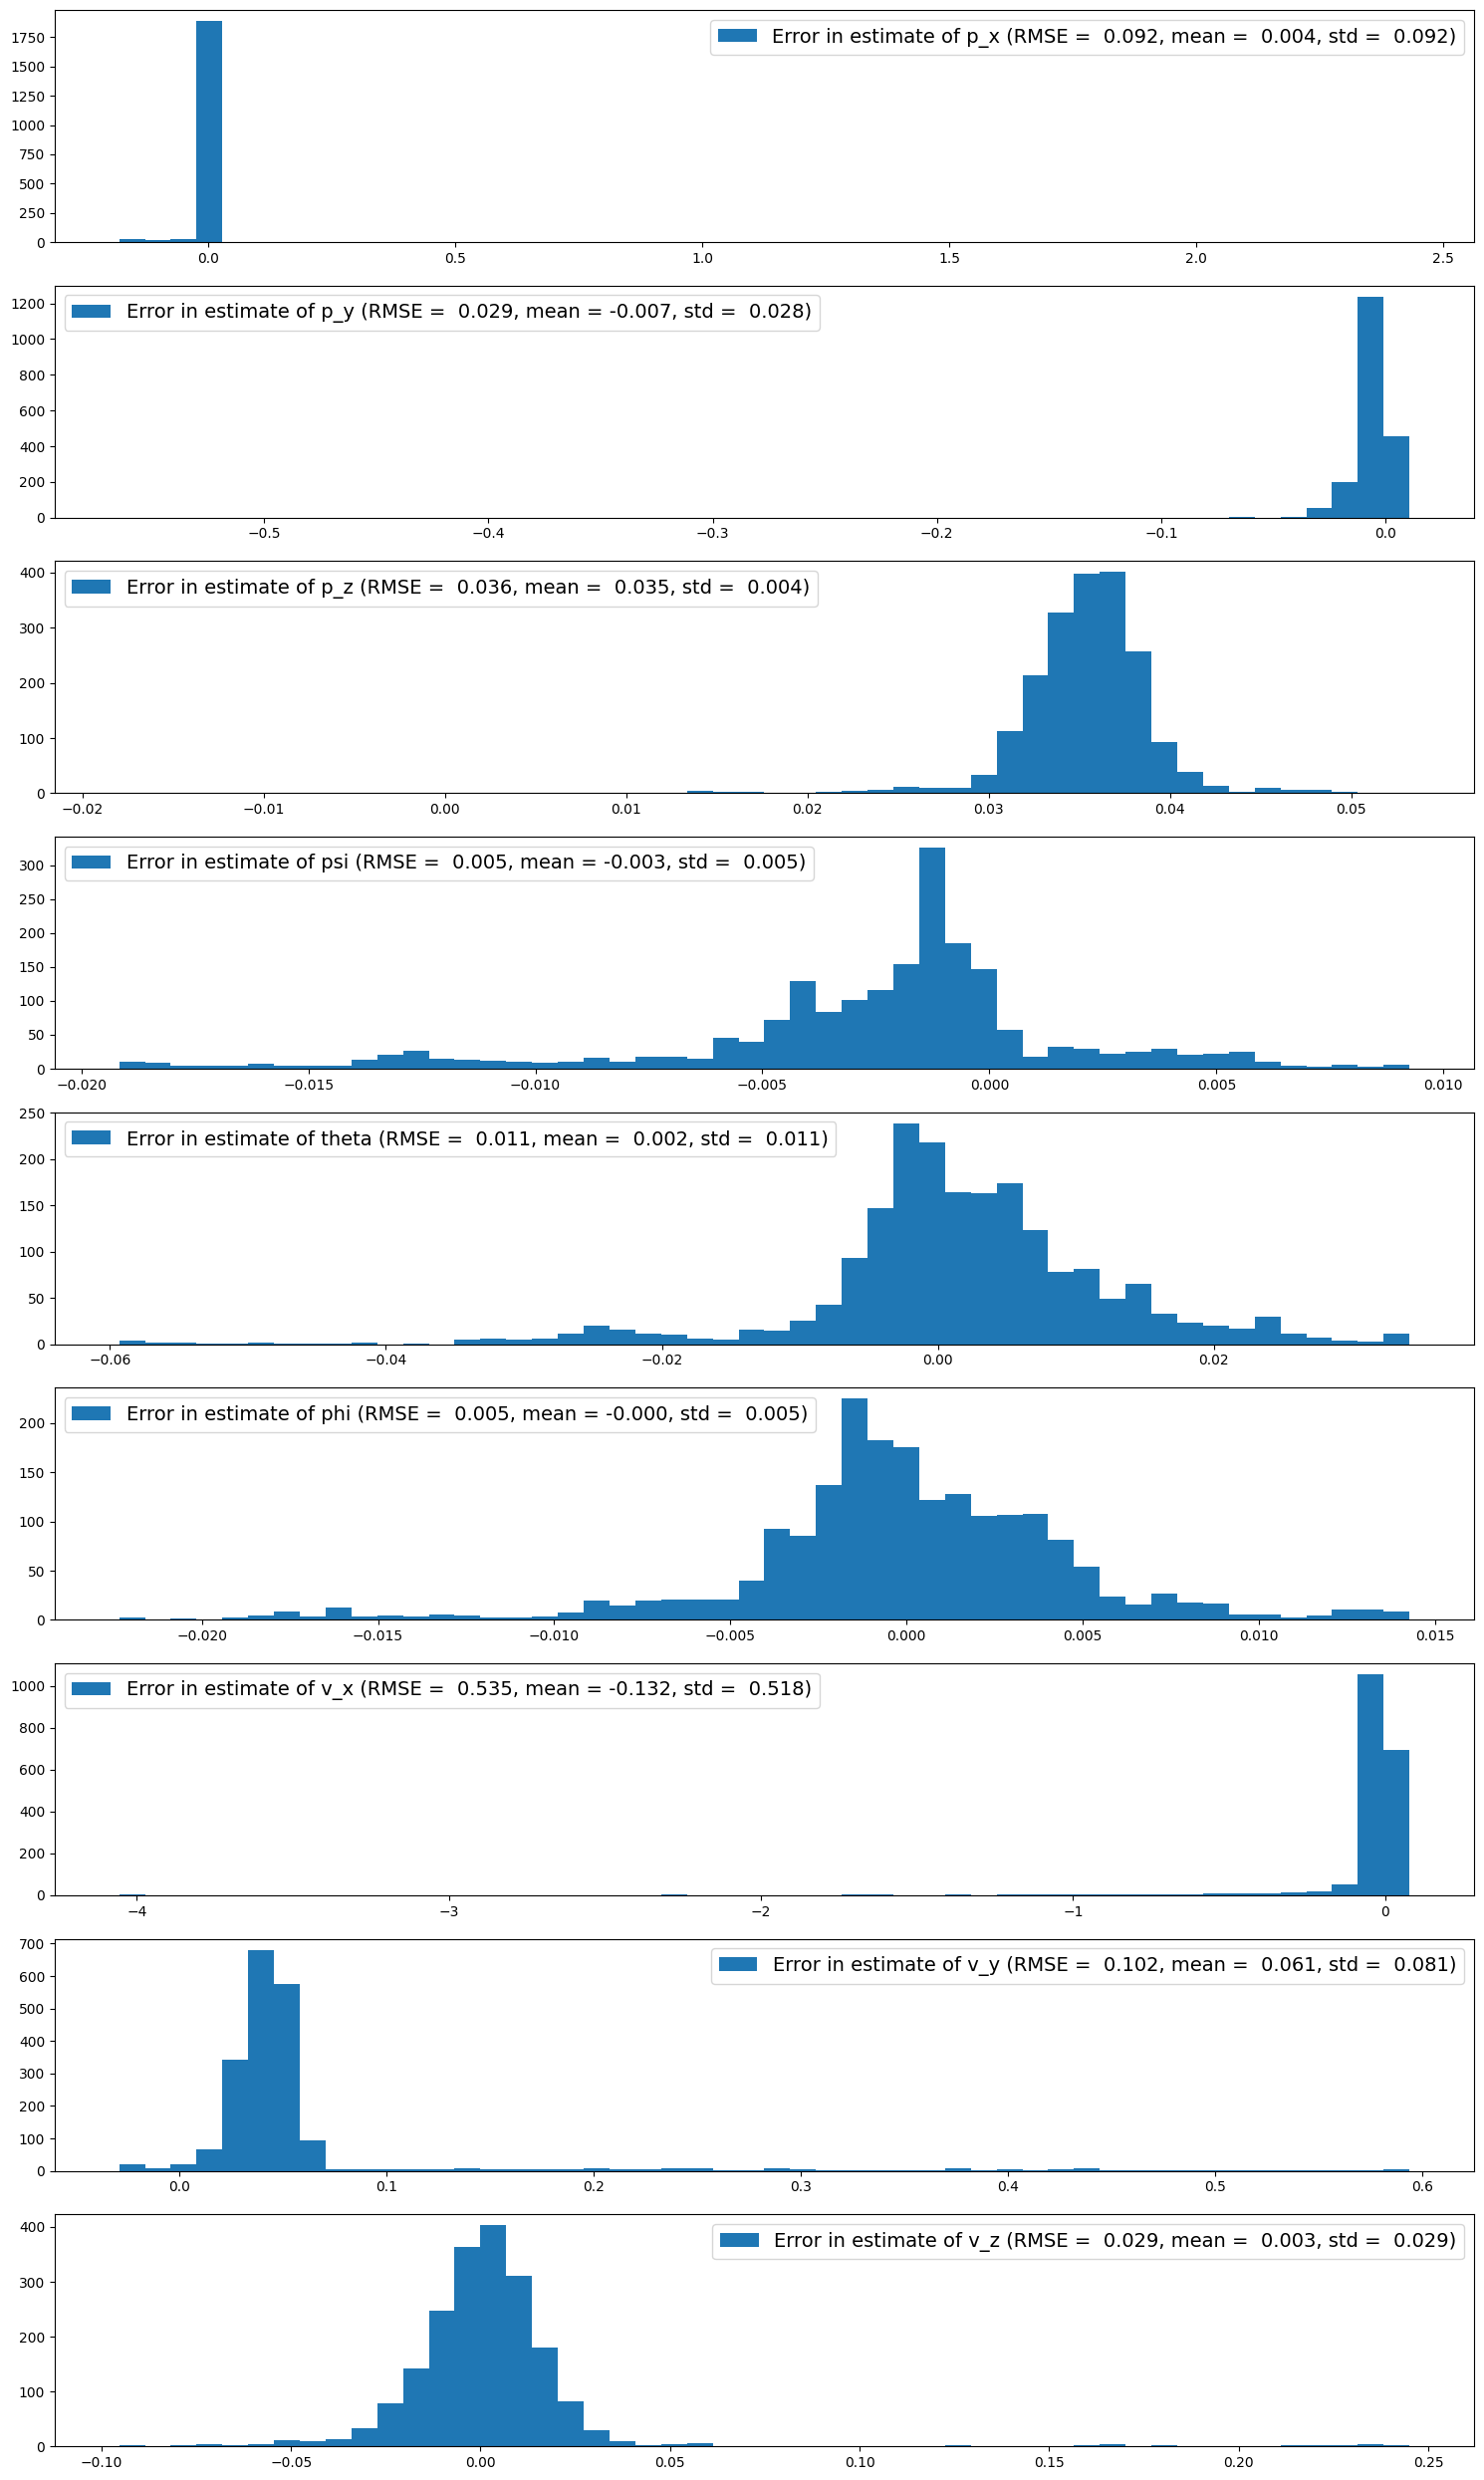

In [86]:
def histogram_plot(t, s_err, name, ax):
    label = f'Error in estimate of {name} ' + \
            f'(RMSE = {np.sqrt(np.mean(s_err**2)):6.3f}, ' + \
            f'mean = {np.mean(s_err):6.3f}, ' + \
            f'std = {np.std(s_err):6.3f})'
    ax.hist(s_err, 50, label=label)
    ax.legend(fontsize=14)

fig, (ax_p_x,
      ax_p_y,
      ax_p_z,
      ax_psi,
      ax_theta,
      ax_phi,
      ax_v_x,
      ax_v_y,
      ax_v_z) = plt.subplots(9, 1, figsize=(15, 25))
histogram_plot(t, p_x_err, 'p_x', ax_p_x)
histogram_plot(t, p_y_err, 'p_y', ax_p_y)
histogram_plot(t, p_z_err, 'p_z', ax_p_z)
histogram_plot(t, psi_err, 'psi', ax_psi)
histogram_plot(t, theta_err, 'theta', ax_theta)
histogram_plot(t, phi_err, 'phi', ax_phi)
histogram_plot(t, v_x_err, 'v_x', ax_v_x)
histogram_plot(t, v_y_err, 'v_y', ax_v_y)
histogram_plot(t, v_z_err, 'v_z', ax_v_z)
fig.tight_layout()
plt.show()

## 3.3 Apply observer for gain matrix chosen by weights from model equal Q, R

**FIXME.** Copy all cells from Section 3.2 here. Then, modify your observer implementation to use weights $Q$ and $R$ chosen by looking at model error variance.

In [72]:
# Get inputs
w_x_offline = data_drone['ae483log.w_x']
w_y_offline = data_drone['ae483log.w_y']
w_z_offline = data_drone['ae483log.w_z']
a_z_offline = data_drone['ae483log.a_z']

# Get outputs
n_x_offline = data_drone['ae483log.n_x']
n_y_offline = data_drone['ae483log.n_y']
r_offline = data_drone['ae483log.r']
p_x_mocap_offline   = data_drone['ae483log.p_x_mocap']
p_y_mocap_offline   = data_drone['ae483log.p_y_mocap']
p_z_mocap_offline   = data_drone['ae483log.p_z_mocap']
psi_mocap_offline   = data_drone['ae483log.psi_mocap']
theta_mocap_offline = data_drone['ae483log.theta_mocap']
phi_mocap_offline   = data_drone['ae483log.phi_mocap']


# Initialize estimates
p_x = 0.
p_y = 0.
p_z = 0.
psi = 0.
theta = 0.
phi = 0.
v_x = 0.
v_y = 0.
v_z = 0.
a_z_0 = a_z_offline[0]

# Initialize storage (do not change)
p_x_offline = np.zeros(len(t))
p_y_offline = np.zeros(len(t))
p_z_offline = np.zeros(len(t))
psi_offline = np.zeros(len(t))
theta_offline = np.zeros(len(t))
phi_offline = np.zeros(len(t))
v_x_offline = np.zeros(len(t))
v_y_offline = np.zeros(len(t))
v_z_offline = np.zeros(len(t))

# Iterate over all time steps
for i in range(len(t)):
    # Get measurements (do not change)
    w_x = w_x_offline[i]
    w_y = w_y_offline[i]
    w_z = w_z_offline[i]
    a_z = a_z_offline[i]
    n_x = n_x_offline[i]
    n_y = n_y_offline[i]
    r = r_offline[i]
    p_x_mocap = p_x_mocap_offline[i]
    p_y_mocap = p_y_mocap_offline[i]
    p_z_mocap = p_z_mocap_offline[i]
    psi_mocap = psi_mocap_offline[i]
    theta_mocap  = theta_mocap_offline[i]
    phi_mocap = phi_mocap_offline[i]


    
    # Compute each element of:
    #
    #  C x + D u - y = 0
    err_0 = -k_flow*w_y + (k_flow*v_x)/p_z_eq - n_x
    err_1 = k_flow*w_x + (k_flow*v_y)/p_z_eq - n_y
    err_2 = -d_carpet + p_z - r
    err_3 = p_x - p_x_mocap
    err_4 = p_y - p_y_mocap
    err_5 = p_z - p_z_mocap
    err_6 = psi - psi_mocap
    err_7 = theta - theta_mocap
    err_8 = phi - phi_mocap
    p_x += dt*(v_x - (0.12065930945868715*err_0 + 1.007433574471146*err_3 + 0.001247074400481345*err_7))
    p_y += dt*(v_y - (0.1206593094586871*err_1 + 1.0074335744711462*err_4 + -0.0012470744004816274*err_8))
    p_z += dt*(v_z - (1.09868411346781*err_2 + 1.09868411346781*err_5))
    psi += dt*(w_z - (1.0000000000000002*err_6))
    theta += dt*(w_y - (0.9826695710372233*err_0 + 0.001247074400481345*err_3 + 0.18536169766960864*err_7))
    phi += dt*(w_x - (-0.9826695710372217*err_1 + -0.0012470744004816274*err_4 + 0.18536169766960833*err_8))
    v_x += dt*(a_z_0*theta - (1.8278027410853745*err_0 + 0.014741315562657795*err_3 + 0.120055736316319*err_7))
    v_y += dt*(-a_z_0*phi - (1.8278027410853737*err_1 + 0.014741315562657788*err_4 + -0.12005573631631881*err_8))
    v_z += dt*(a_z-a_z_0 - (0.7071067811865481*err_2 + 0.7071067811865481*err_5))

    # Store estimates (do not change)
    p_x_offline[i] = p_x
    p_y_offline[i] = p_y
    p_z_offline[i] = p_z
    psi_offline[i] = psi
    theta_offline[i] = theta
    phi_offline[i] = phi
    v_x_offline[i] = v_x
    v_y_offline[i] = v_y
    v_z_offline[i] = v_z

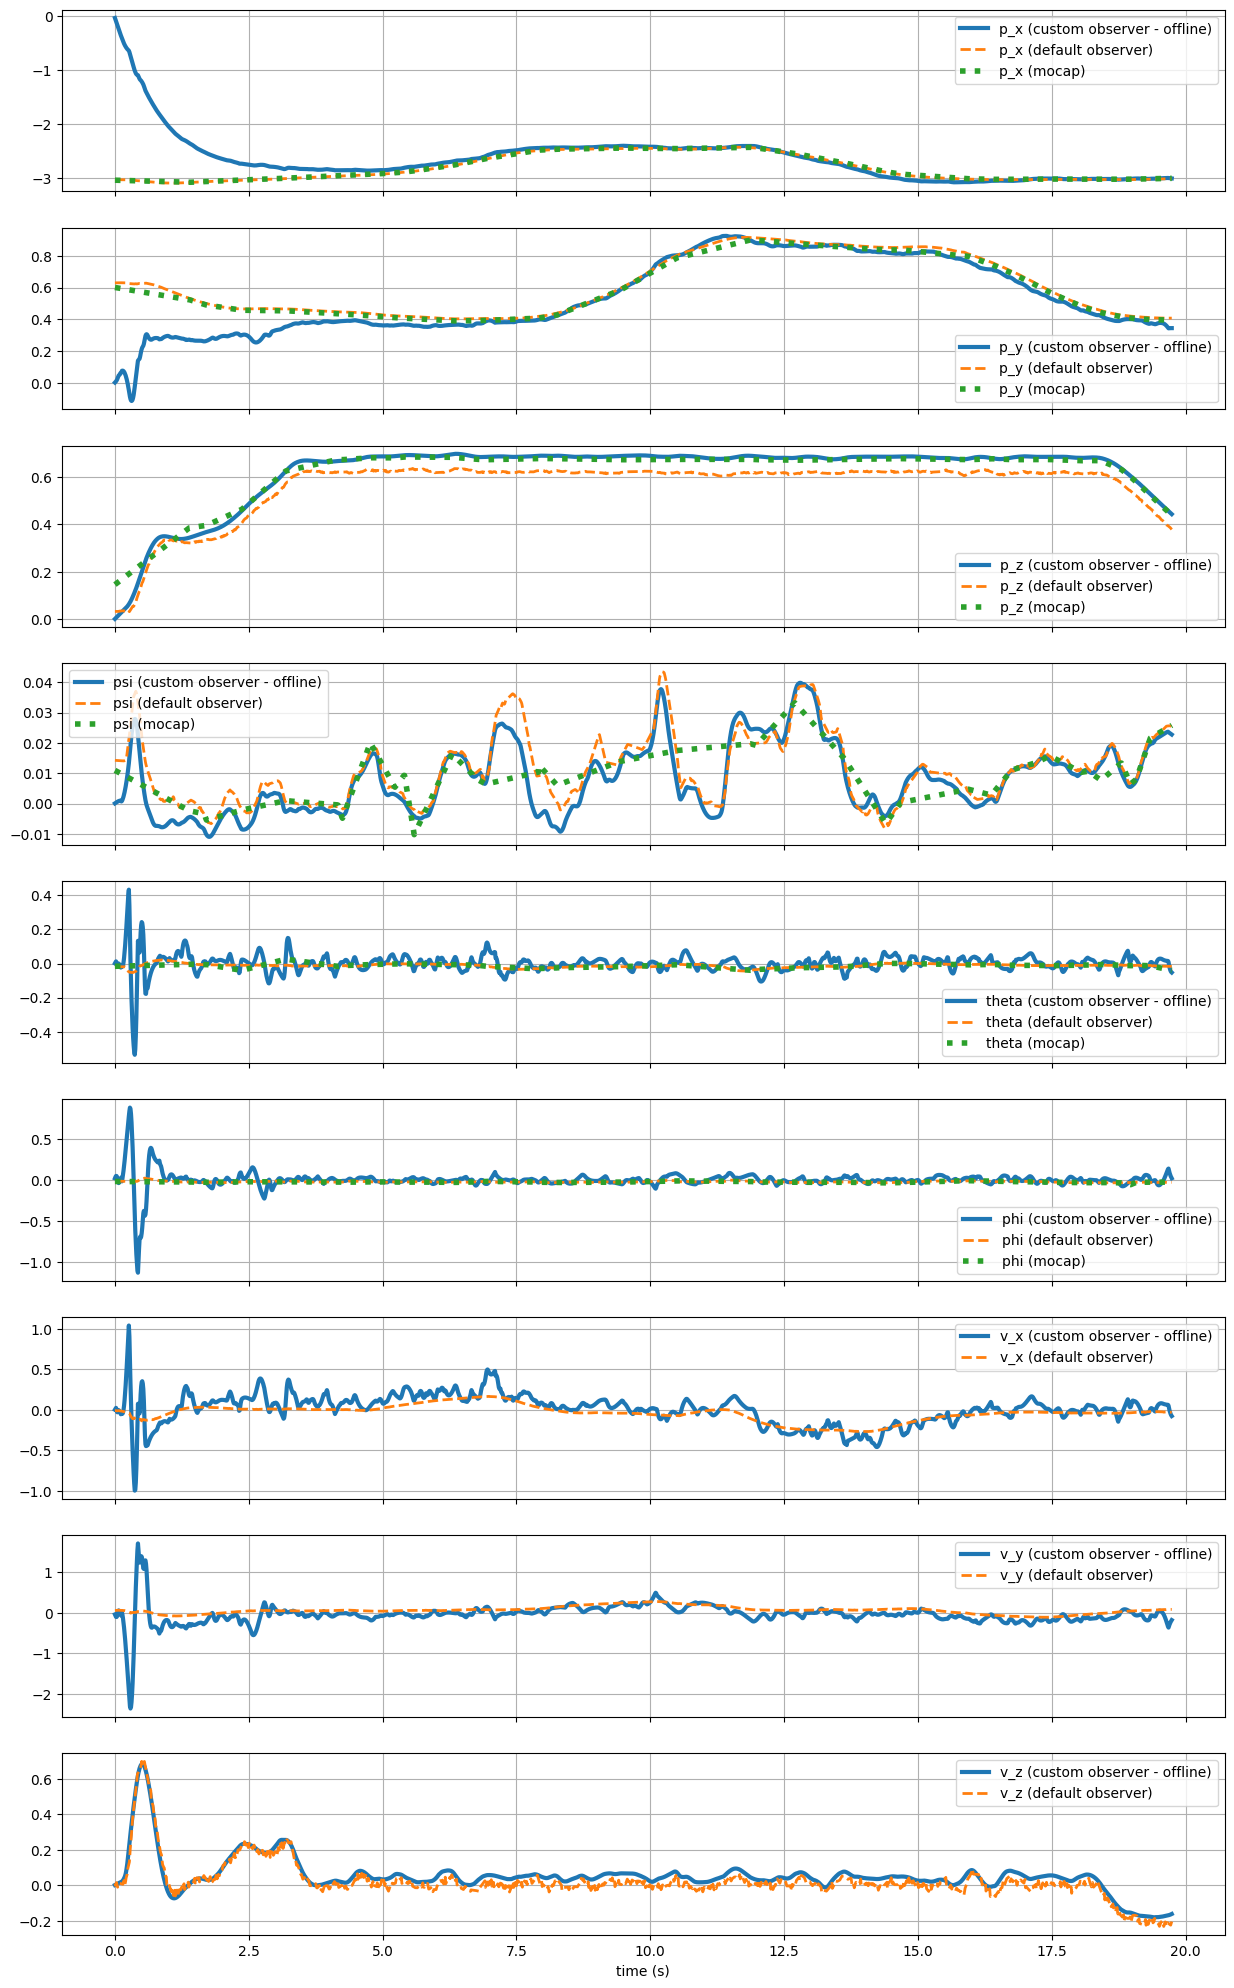

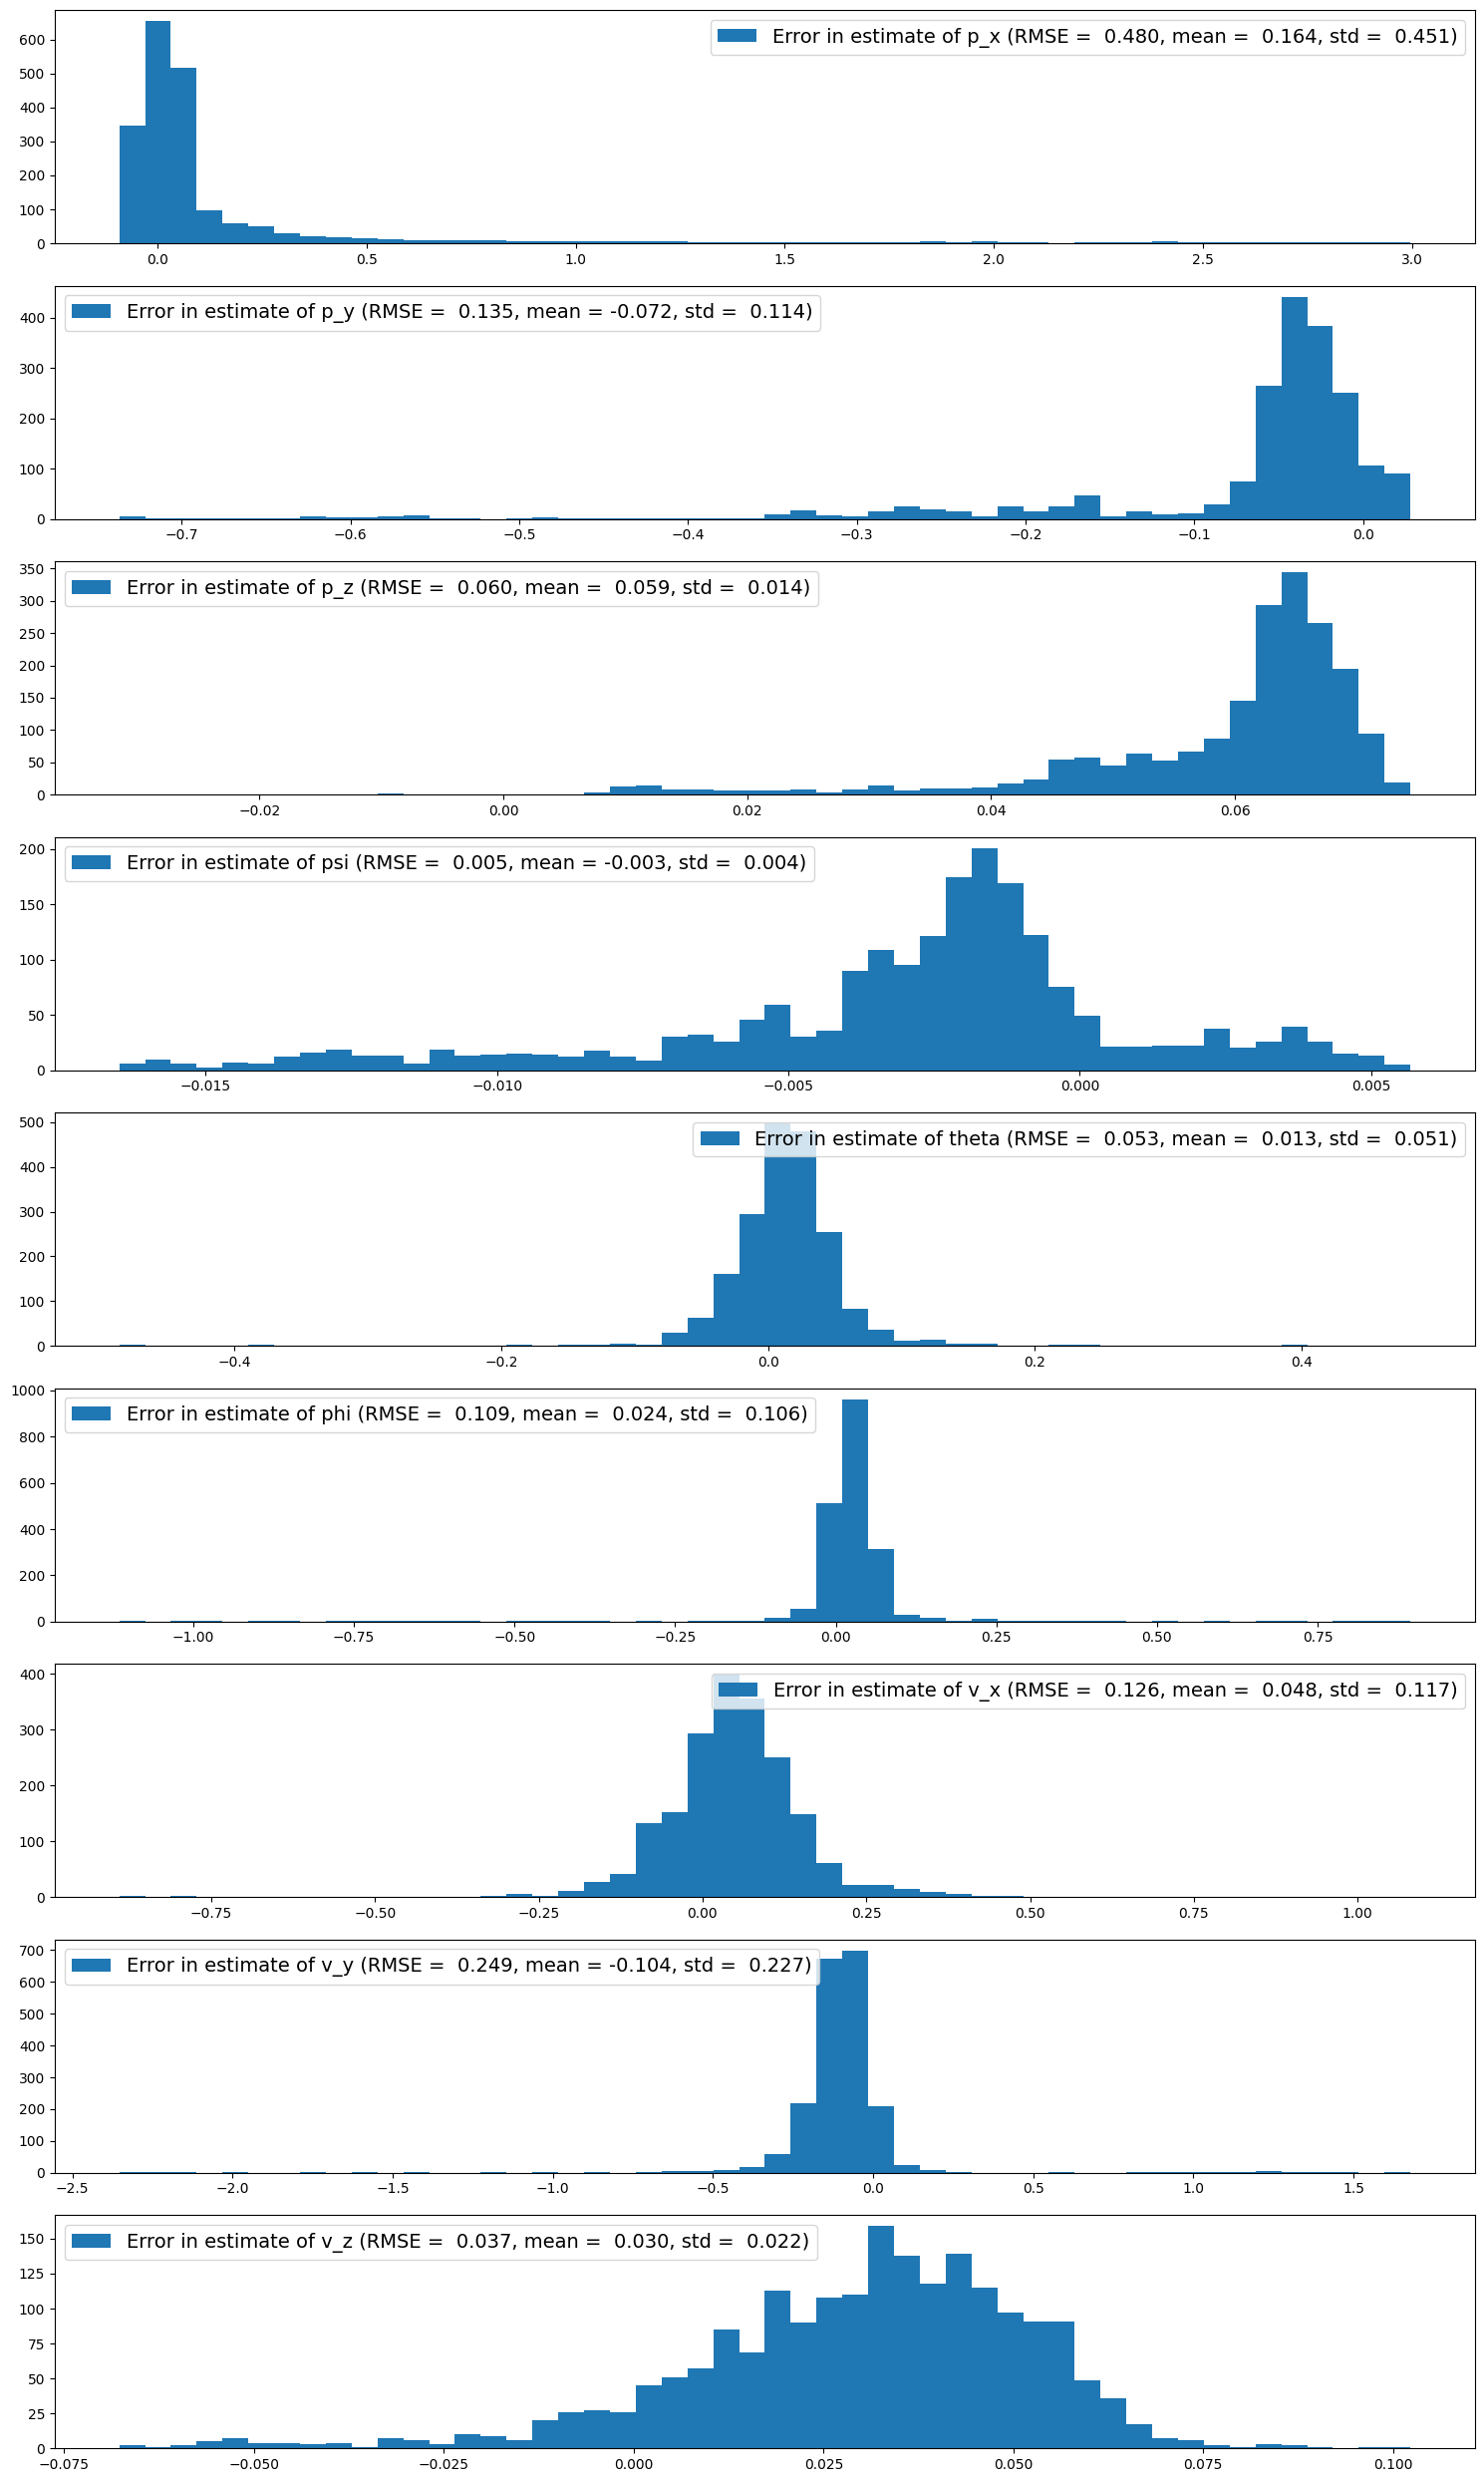

In [73]:
p_x_err = p_x_offline - p_x_default
p_y_err = p_y_offline - p_y_default
p_z_err = p_z_offline - p_z_default
psi_err = psi_offline - psi_default
theta_err = theta_offline - theta_default
phi_err = phi_offline - phi_default
v_x_err = v_x_offline - v_x_default
v_y_err = v_y_offline - v_y_default
v_z_err = v_z_offline - v_z_default

fig, (ax_p_x,
      ax_p_y,
      ax_p_z,
      ax_psi,
      ax_theta,
      ax_phi,
      ax_v_x,
      ax_v_y,
      ax_v_z) = plt.subplots(9, 1, figsize=(15, 25), sharex=True)
comparison_plot(t, p_x_offline, p_x_default, 'p_x', ax_p_x, s_mocap=p_x_mocap_offline)
comparison_plot(t, p_y_offline, p_y_default, 'p_y', ax_p_y, s_mocap=p_y_mocap_offline)
comparison_plot(t, p_z_offline, p_z_default, 'p_z', ax_p_z, s_mocap=p_z_mocap_offline)
comparison_plot(t, psi_offline, psi_default, 'psi', ax_psi, s_mocap=psi_mocap_offline)
comparison_plot(t, theta_offline, theta_default, 'theta', ax_theta, s_mocap=theta_mocap_offline)
comparison_plot(t, phi_offline, phi_default, 'phi', ax_phi, s_mocap=phi_mocap_offline)
comparison_plot(t, v_x_offline, v_x_default, 'v_x', ax_v_x)
comparison_plot(t, v_y_offline, v_y_default, 'v_y', ax_v_y)
comparison_plot(t, v_z_offline, v_z_default, 'v_z', ax_v_z)
ax_v_z.set_xlabel('time (s)')
plt.show()

fig, (ax_p_x,
      ax_p_y,
      ax_p_z,
      ax_psi,
      ax_theta,
      ax_phi,
      ax_v_x,
      ax_v_y,
      ax_v_z) = plt.subplots(9, 1, figsize=(15, 25))
histogram_plot(t, p_x_err, 'p_x', ax_p_x)
histogram_plot(t, p_y_err, 'p_y', ax_p_y)
histogram_plot(t, p_z_err, 'p_z', ax_p_z)
histogram_plot(t, psi_err, 'psi', ax_psi)
histogram_plot(t, theta_err, 'theta', ax_theta)
histogram_plot(t, phi_err, 'phi', ax_phi)
histogram_plot(t, v_x_err, 'v_x', ax_v_x)
histogram_plot(t, v_y_err, 'v_y', ax_v_y)
histogram_plot(t, v_z_err, 'v_z', ax_v_z)
fig.tight_layout()
plt.show()

## 3.4 Summary and discussion

The following table reports the RMSE in each state estimate:

|  | $p_x$ | $p_y$ | $p_z$ | $\psi$ | $\theta$ | $\phi$ | $v_x$ | $v_y$ | $v_z$ |
| --: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
| RMSE with equal weights | 0.049 | 0.183 | 0.065 | 0.001 | 0.016 | 0.017 | 0.076 | 0.068 | 0.053 |
| RMSE with weights from error model variance | 0.089 | 0.190 | 0.006 | 0.001 | 0.016 | 0.017 | 0.068 | 0.067 | 0.053 |

**Modify the text in this cell** to answer the following questions:

* Which observer performs better, the one derived from equal weights or the one derived from weights based on error model variance? Why? (Make reference to your table of results when answering this question.)
* Is there a difference in what happens to the error in your estimate of (1) observable states and (2) non-observable states over time? Why? (Make reference to your plots when answering this question.)
* We have defined "error" as the difference between the state estimates from your custom observer (implemented offline) and the state estimates from the default observer. Are the state estimates from the default observer really correct? To what extent are any of these estimates the same as what you get from the motion capture system? (Think about the difference between observable and non-observable states when answering this question.)